# Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import (
    mean_absolute_error, mean_absolute_percentage_error,
    root_mean_squared_error
)

%matplotlib inline

Importing plotly failed. Interactive plots will not work.


In [ ]:
air_data: pd.DataFrame = pd.read_csv('../Data/london_air_quality_2010_2023_top5_sites.csv')

# Cleaning

In [ ]:
# Converting to datetime, using format to interpret format
air_data['datetime'] = pd.to_datetime(air_data['datetime'])

# Aggregate daily across all sites
no2_df: pd.DataFrame = (
    air_data
    .resample('d', on='datetime') # Aggregating daily
    .agg(y=('no2_level', 'mean')) # Getting the average no2 and naming it y for prophet
    .reset_index() # Making datetime a column again after the .agg
    .rename(columns={'datetime':'ds'}) # Renaming to prophet format
)
no2_df

,ds,y
0,2010-01-01,54.434167
1,2010-01-02,73.595833
2,2010-01-03,42.633333
3,2010-01-04,89.274167
4,2010-01-05,92.711765
...,...,...
5107,2023-12-26,33.535714
5108,2023-12-27,20.136111
5109,2023-12-28,15.618056
5110,2023-12-29,25.347222


We could interpolate missing values, but it's generally safer to let Prophet simply ignore them.

In [ ]:
no2_df.dropna(inplace=True)

# Incorporating External Regressors

We'll need to gather this extra data from somewhere. In the sample solution with the monthly data a csv is downloaded from Kaggle. Unfortunately the timespan of that csv doesn't line up with our daily dataset so here I am pulling weather information from an API using the `requests` library. In both cases we are bringing in weather patterns as potential predictors of pollution, but there may be other data that you think could help make these predictions beyond just weather.

I want my model to be able to use current weather data that I already have to forecast future pollution levels. This means I need to pair pollution levels with weather forecasts from the past in order for the model to learn how to use past weather to predict future pollution.

Ideally we would get weather data from earlier than our pollution data starts so that we can use past weather to predict future pollution, however it just so happens that this API's earliest available data is 2010-01-01, which is actually the first date of our pollution data as well. This means that when we use `.shift()` later the first few days of pollution data won't have numbers for the past weather and we'll just have to drop them from the training set.

All this is to say that ideally we would gather weather data from dates before the start of our pollution data, but it just happens to be that this API doesn't go back that far.

In [ ]:
# Pulling weather forecasts from API
# https://open-meteo.com/en/docs/historical-weather-api

import requests

# Last day of pollution data
end_date = no2_df['ds'].max()

# --- API Request ---
base_url = 'https://archive-api.open-meteo.com/v1/archive'
# Specifying parameters for request
params = {
    'latitude': 51.5072, 'longitude': 0.1276, #london's coordinates
    'start_date': '2010-01-01', # Earliest available through the API
    'end_date': end_date.strftime('%Y-%m-%d'), #formatting date for API
    'daily': ['wind_speed_10m_max', 'precipitation_sum'], #info to use as external regressors
    'timezone_abbreviation': 'CEST' # requested in API docs
}
# Requesting data from API
response = requests.get(url=base_url, params=params)
# Converting json response to dataframe
weather_data = pd.DataFrame(response.json()['daily'])
weather_data

,time,wind_speed_10m_max,precipitation_sum
0,2010-01-01,19.1,0.0
1,2010-01-02,16.6,0.0
2,2010-01-03,13.6,0.0
3,2010-01-04,11.9,0.0
4,2010-01-05,12.7,1.6
...,...,...,...
5107,2023-12-26,24.0,0.1
5108,2023-12-27,36.4,5.4
5109,2023-12-28,38.8,0.2
5110,2023-12-29,28.2,1.0


While this external data is already on a daily frequency, using `.resample` will make sure any missing days are still given rows, just with NaN, which `.interpolate()` can then fill in. It also means that if we have duplicate entries for the same date they will be averaged. Lastly, if we decided to go back and get weather data that is at a higher frequency instead, this code would still work, automatically aggregating it into the desired frequency.

In [ ]:
# Convert date to datetime
weather_data['time'] = pd.to_datetime(weather_data['time'], format='%Y-%m-%d')
# Ensuring fixed frequency (see text above ^)
daily_weather: pd.DataFrame = weather_data.resample('d', on='time').mean()

Right now our dataset has the weather for each day, but if the model learns the relationship between the weather and pollution on the same day, it won't help us forecast future pollution unless we know what the future weather will look like. We need to make our regressors information that we could have at prediction time. To do this we can shift the data so that pollution is paired with past weather; that will make it so that we can use current weather to predict future pollution.

We may also want to give the model several days of lagged weather information. Instead of just predicting the future based on today's weather, we could give it the last three days of weather. To do this we can create new columns for each of these lagged terms.

Keep in mind that if I want to predict 7 days into the future, the minimum lag will have to be 7 days. I won't have access to the-weather-6-days-from-now so something like precipitation_lag_1 won't be usable for that 7 day forecast.

In [ ]:
# Adding lagged terms
horizon: int = 1 # how far into the future I want to predict is the minimum amount of lag
num_lagged_terms: int = 7 # how many days of past/known weather to use

# Setting up empty dataframe for lagged terms
regressors_df = pd.DataFrame(index=daily_weather.index)

# For each weather variable...
for regressor in daily_weather.columns:
    # For each "lagged term" we want the model to have access to...
    for n in range(num_lagged_terms):
        lag: int = n + horizon # how far into the future I want to predict is the minimum amount of lag
        # Shift weather data to get lagged feature, then add lagged feature to regressors dataframe
        regressors_df[f'{regressor}_lag_{lag}'] = daily_weather[regressor].shift(lag)

regressors_df

,wind_speed_10m_max_lag_1,wind_speed_10m_max_lag_2,wind_speed_10m_max_lag_3,wind_speed_10m_max_lag_4,wind_speed_10m_max_lag_5,wind_speed_10m_max_lag_6,wind_speed_10m_max_lag_7,precipitation_sum_lag_1,precipitation_sum_lag_2,precipitation_sum_lag_3,precipitation_sum_lag_4,precipitation_sum_lag_5,precipitation_sum_lag_6,precipitation_sum_lag_7
time,,,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,19.1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,16.6,19.1,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2010-01-04,13.6,16.6,19.1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2010-01-05,11.9,13.6,16.6,19.1,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-26,29.1,32.2,29.5,30.1,34.9,26.5,25.1,2.3,2.2,0.0,0.5,0.2,0.0,13.1
2023-12-27,24.0,29.1,32.2,29.5,30.1,34.9,26.5,0.1,2.3,2.2,0.0,0.5,0.2,0.0
2023-12-28,36.4,24.0,29.1,32.2,29.5,30.1,34.9,5.4,0.1,2.3,2.2,0.0,0.5,0.2


In [ ]:
# Interpolate any missing dates before merge
previous_daily_weather: pd.DataFrame = regressors_df.interpolate()

# Merge weather data with target data
df: pd.DataFrame = pd.merge(
    no2_df, previous_daily_weather,
    left_on='ds', right_index=True
)

# Dropping those first days that don't have historical weather (due to API cutoff mentioned above ^)
df.dropna(inplace=True)

df.head()

,ds,y,wind_speed_10m_max_lag_1,wind_speed_10m_max_lag_2,wind_speed_10m_max_lag_3,wind_speed_10m_max_lag_4,wind_speed_10m_max_lag_5,wind_speed_10m_max_lag_6,wind_speed_10m_max_lag_7,precipitation_sum_lag_1,precipitation_sum_lag_2,precipitation_sum_lag_3,precipitation_sum_lag_4,precipitation_sum_lag_5,precipitation_sum_lag_6,precipitation_sum_lag_7
7,2010-01-08,53.695763,22.3,21.7,12.7,11.9,13.6,16.6,19.1,0.1,5.3,1.6,0.0,0.0,0.0,0.0
8,2010-01-09,31.515000,18.0,22.3,21.7,12.7,11.9,13.6,16.6,0.0,0.1,5.3,1.6,0.0,0.0,0.0
9,2010-01-10,35.362500,28.5,18.0,22.3,21.7,12.7,11.9,13.6,0.6,0.0,0.1,5.3,1.6,0.0,0.0
10,2010-01-11,62.899167,24.3,28.5,18.0,22.3,21.7,12.7,11.9,3.3,0.6,0.0,0.1,5.3,1.6,0.0
11,2010-01-12,68.021930,9.1,24.3,28.5,18.0,22.3,21.7,12.7,0.5,3.3,0.6,0.0,0.1,5.3,1.6


# Train Test Split

Determining split index by desired training data proportion

In [ ]:
# Calculating split location
total_months = len(df)
train_size = 0.9
idx_split = int(total_months * train_size)

# Separating training months from testing months
train_df: pd.DataFrame = df.iloc[:idx_split]
test_df: pd.DataFrame = df.iloc[idx_split:]

# Modeling

In [ ]:
# Setting up scoring

def score_model(
    y_true : pd.Series,
    y_pred : pd.Series,
) -> dict[str, float]:
    "Compute various scores and return dict"

    scores = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'RMSE': root_mean_squared_error(y_true, y_pred)
    }
    return scores

# Setting up scoreboard
scoreboard = pd.DataFrame(columns=['Model', 'MAE', 'MAPE', 'RMSE']).set_index('Model')

In [ ]:
# Initializing model with regressors and holidays

model = Prophet()

# Incoporating additional regressors
regressors = [col for col in train_df.columns if col not in ['ds', 'y']]
for regressor in regressors:
    model.add_regressor(regressor, mode='multiplicative') #assumes weather multiplies/divides pollution rather than adding/subtracting

# Incorporating holidays
model.add_country_holidays(country_name='UK')

# Fitting model to training data
model.fit(train_df)

18:19:56 - cmdstanpy - INFO - Chain [1] start processing
18:19:56 - cmdstanpy - INFO - Chain [1] done processing


## Forecasting

We cannot use `.make_future_dataframe` in this case because we can only make predictions for dates that we have the weather data for. This makes things simpler to code but it means we cannot forecast missing days.

In [ ]:
# Forecasting testing window

# If we only care about the forecasts for our testing data we could run this
forecast: pd.DataFrame = model.predict(test_df)
# If we want to see how well it fits the training data as well we could run this
forecast: pd.DataFrame = model.predict(df)

In [ ]:
# Scoring model

y_test: pd.Series = test_df['y']
# We'll have to filter the full forecast to just the predictions we have the labels for
test_preds: pd.Series = forecast.loc[forecast['ds'].isin(test_df['ds']), 'yhat']

# Insert scores into scoreboard
scoreboard.loc['Prophet w External Regressors', :] = score_model(y_test, test_preds)
scoreboard

,MAE,MAPE,RMSE
Model,,,
Prophet w External Regressors,7.575122,0.281335,9.986548


### Plotting

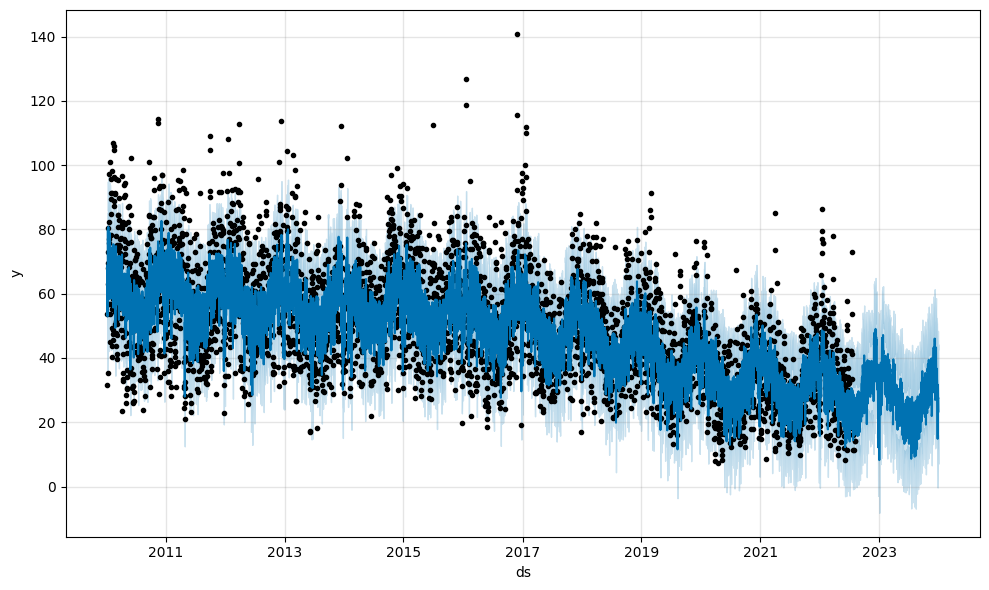

In [ ]:
# Plotting forecast with built in plotting function
model.plot(forecast);

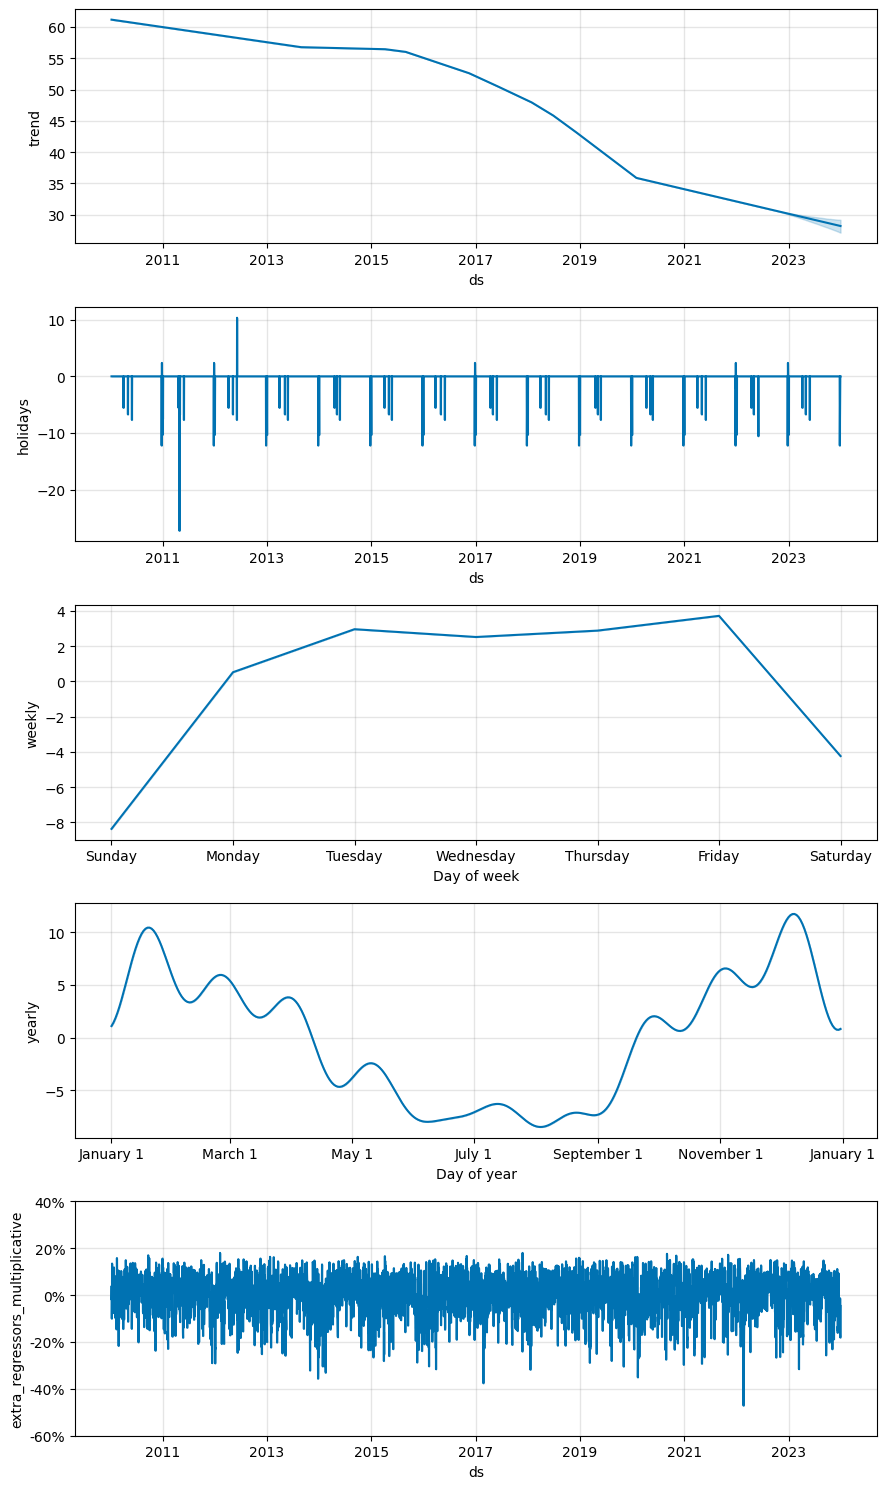

In [ ]:
# Plotting trend and seasonal components
model.plot_components(forecast);

We'll have to use custom plots to be able to zoom into the prediction region

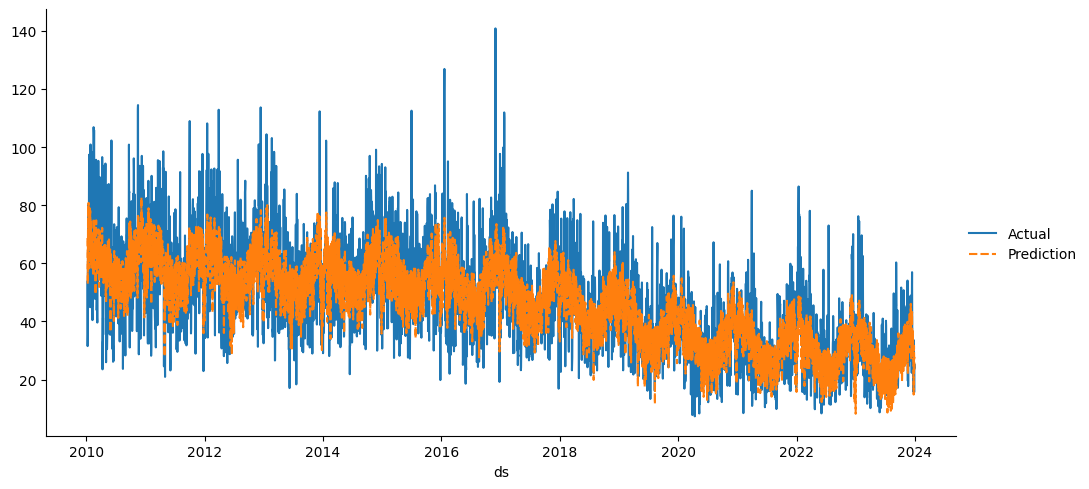

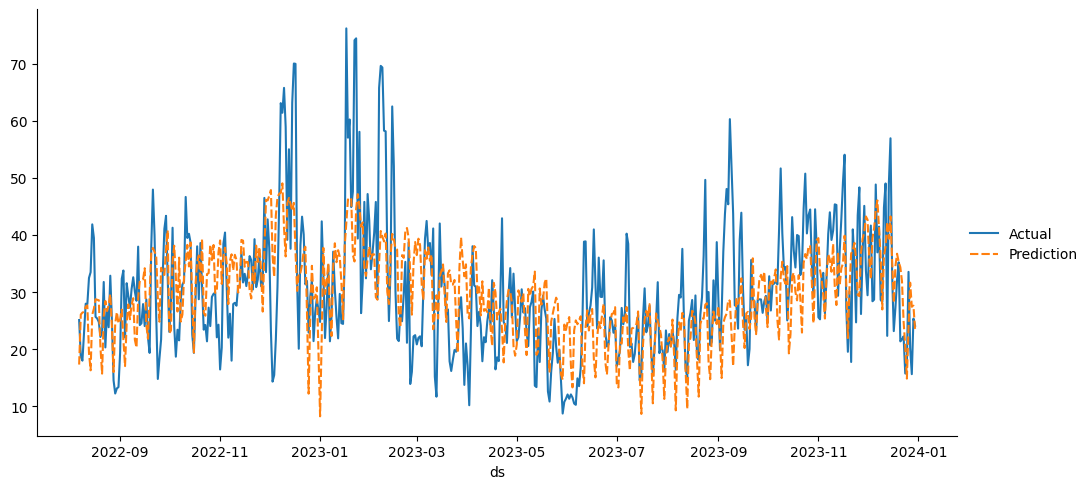

In [ ]:
# Gathering plot info into data frame
plot_df = df[['ds', 'y']].rename(columns={'y': 'Actual'}).set_index('ds')
plot_df['Prediction'] = forecast.set_index('ds')['yhat'] #common index will be aligned

# Plotting
sns.relplot(
    plot_df,
    kind='line',
    aspect=2
)
# Zooming in on prediction region
sns.relplot(
    plot_df.iloc[idx_split:],
    kind='line',
    aspect=2
);

With some matplotlib we can bring the confidence regions back into our custom plots

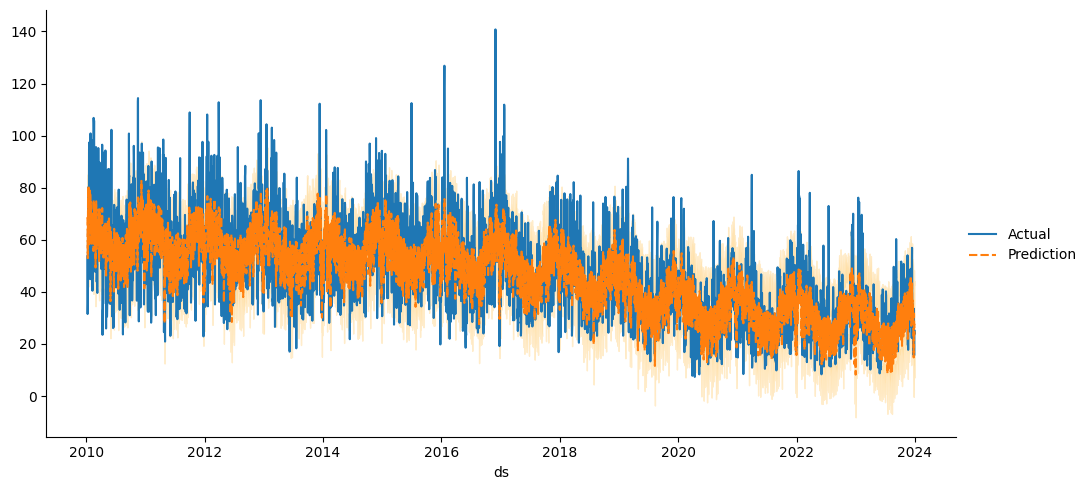

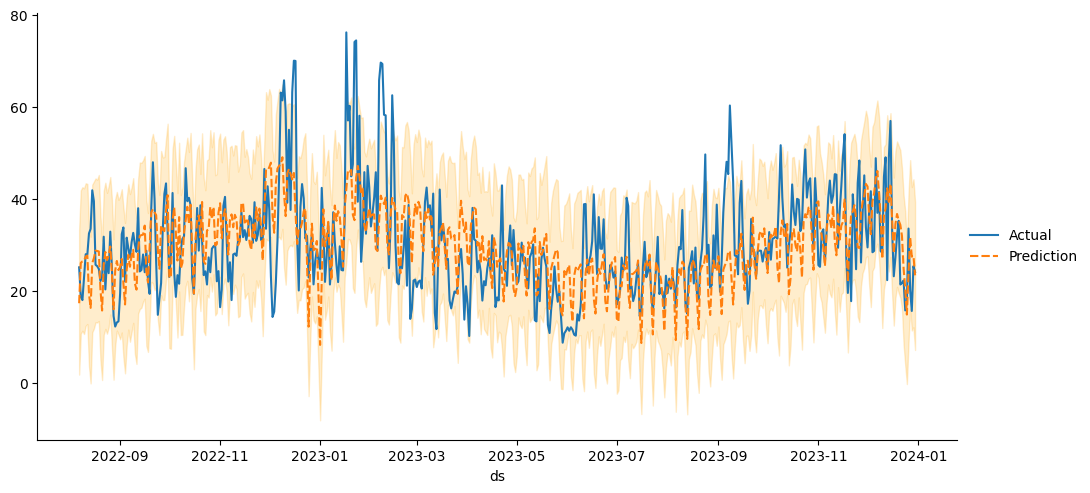

In [ ]:
# Plotting
g_full = sns.relplot(
    plot_df,
    kind='line',
    aspect=2
)
g_zoomed = sns.relplot(
    plot_df.iloc[idx_split:],
    kind='line',
    aspect=2
)

# Getting axes for shading confidence regions
ax_full = g_full.ax
ax_zoomed = g_zoomed.ax

# Fill confidence regions
for ax, forecasted in [(ax_full, forecast), (ax_zoomed, forecast.iloc[idx_split:])]:
    ax.fill_between(
        forecasted['ds'],           # Dates of prediction region
        forecasted['yhat_lower'],   # Lower confidence bound
        forecasted['yhat_upper'],   # Upper confidence bound
        color='orange',
        alpha=0.2,
        label='Confidence Interval'
    );